# This notebook aims to fill missing data from the wildfire dataset

* [Fill `fuel_type` feature](#Fill-fuel_type-feature)
* [Fill `true_cause` feature](#Fill-true_cause-feature)

In [2]:
# All imports for the project goes here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from helpers import feature_plot, oneHotEnc_to_classes, parse_datetime_features_to_hours, RocCallback
from helpers import datetime_feature_engineering, fill_datetime_with_neighbors, save_model, load_model
from helpers import fire_number_feature_engineering, data_analysis_by_size_class
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import category_encoders as ce
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
from helpers import feature_plot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV


%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
# Loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

In [5]:
# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fuel_type                       4793
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [4]:
# Test missing data
null_counts = test.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      1796
activity_class                  1524
fuel_type                       1247
fire_fighting_start_date        1080
discovered_date                  546
weather_conditions_over_fire     456
fire_position_on_slope           456
fire_type                        434
fire_start_date                  112
fire_origin                        3
dtype: int64

In [6]:
# Get training data only with non null rows
noNaN_train = train.dropna()

In [7]:
datetime_feature_engineering(noNaN_train)

,fire_number,fire_year,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,det_agent_type,...,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,fire_duration,time_to_ex,time_to_uc,time_to_bh2,time_to_bh,time_to_report
4,SWF001,2009,A,55.905933,-113.578850,Indian Reservation,Resident,Piles,Permit Related,UNP,...,Surface,Flat,Clear,C2,1395.0,1161.0,0.0,114.0,234.0,0.0
41,SWF216,2009,B,54.932783,-115.210783,Provincial Land,Power Line Industry,Power Lines,Unpredictable Event,UNP,...,Surface,Flat,Cloudy,C2,1253.0,1203.0,963.0,42.0,50.0,0.0
44,HWF044,2006,B,58.496423,-115.123148,Indian Reservation,Resident,Grass,Permit Related,LKT,...,Surface,Flat,Clear,O1a,1155.0,1115.0,1055.0,0.0,40.0,3.0
53,HWF036,2009,A,58.720683,-118.696617,Indian Reservation,Resident,Children,Burning Substance,UNP,...,Surface,Flat,Clear,O1a,2269.0,2267.0,0.0,0.0,2.0,0.0
68,HWF034,2011,B,58.452807,-114.579165,Indian Reservation,Resident,Grass,Permit Related,LKT,...,Surface,Flat,CB Dry,O1a,2660.0,2610.0,10.0,10.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15847,LWF009,2013,B,55.917117,-110.736367,Indian Reservation,Resident,Debris Disposal,Unsafe Fire,LKT,...,Surface,Flat,Clear,O1a,1188.0,1147.0,104.0,0.0,41.0,2.0
15859,SWF050,2008,C,55.464667,-114.796350,Provincial Park,Power Line Industry,Power Lines,Unpredictable Event,LKT,...,Crown,Middle 1/3,Cloudy,M2,54342.0,51810.0,1912.0,2380.0,2532.0,2.0
15861,GWF159,2008,A,54.859544,-118.777492,Provincial Land,Power Line Industry,Power Lines,Insufficient Buffer,UNP,...,Surface,Flat,Clear,O1b,142.0,5.0,0.0,-1.0,137.0,0.0
15863,SWF202,2006,A,55.949617,-113.730433,Provincial Land,Recreation,All Terrain Vehicles,Hot Exhaust,LKT,...,Surface,Flat,Clear,M2,935.0,865.0,65.0,25.0,70.0,0.0


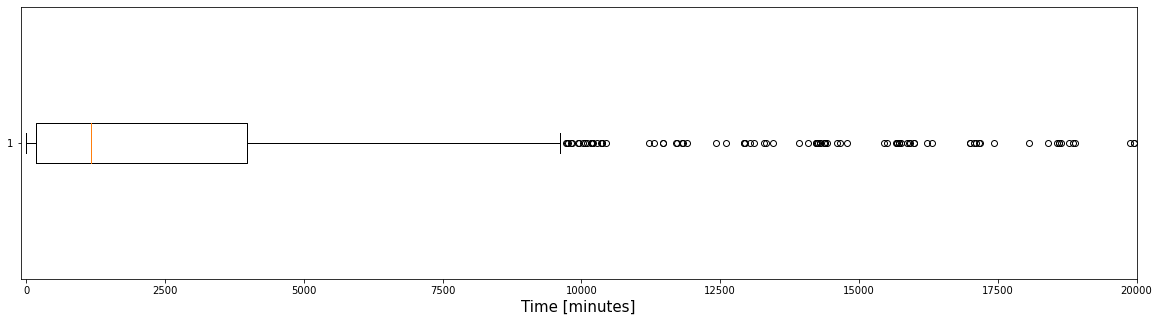

In [210]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['fire_duration'], vert=False)
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-100,20000]);

In [211]:
#plt.figure(figsize=(20,5))
#plt.boxplot(datetime_feature_engineering(noNaN_train)['time_to_ex'], vert=False);
#plt.xlabel('Time [minutes]', fontsize=15)
#plt.xlim([-100,20000]);

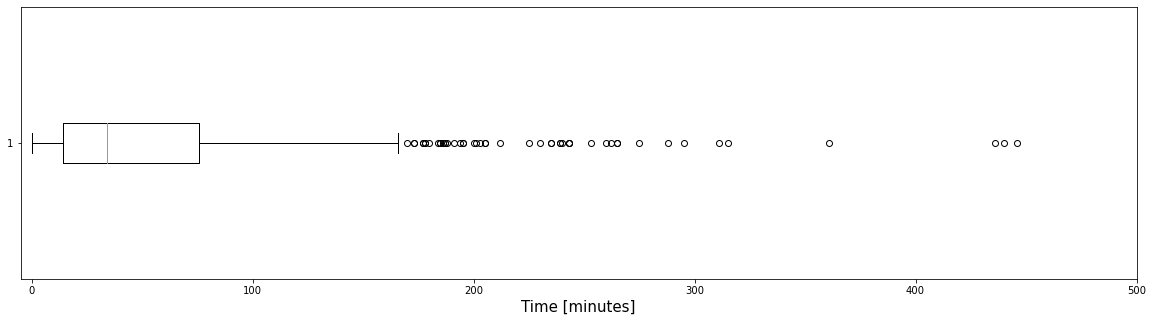

In [212]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['fire_fight_response_time'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-5,500]);

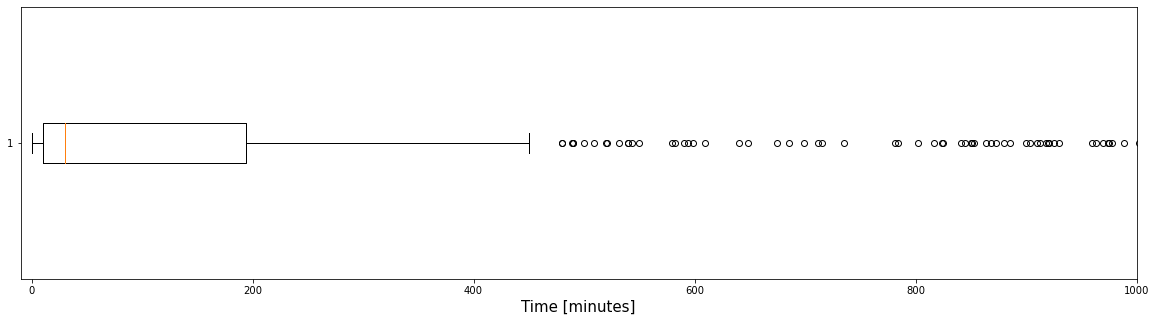

In [213]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['time_to_discover'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-10,1000]);

In [214]:
# Get training data only with non null rows
noNaN_test = test.dropna()
datetime_feature_engineering(noNaN_test)

,fire_number,fire_year,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,det_agent_type,det_agent,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,fire_duration,time_to_ex,fire_fight_response_time,time_to_discover,time_to_report
1,WWF031,2008,54.186250,-115.175200,Provincial Land,Recreation,All Terrain Vehicles,Burning Substance,LKT,IM,HAC1H,Surface,Flat,Clear,M2,2719.0,2590.0,60.0,15.0,0.0
17,RWF051,2009,52.462913,-115.095227,Provincial Land,Power Line Industry,Power Lines,Insufficient Buffer,LKT,RY,FPD Staff,Surface,Flat,Cloudy,O1a,444.0,328.0,28.0,83.0,0.0
31,CWF117,2018,51.142300,-114.721217,Provincial Land,Resident,Transportation,Vehicle Fire,GRP,PATR,FPD Staff,Surface,Flat,Cloudy,O1b,50.0,20.0,0.0,10.0,0.0
32,CWF209,2016,50.184933,-114.319600,Provincial Land,Recreation,Cooking and Warming,Unsafe Fire,UNP,LFS,FPD Staff,Surface,Bottom,Clear,D1,2674.0,1594.0,1041.0,39.0,0.0
33,PWF010,2010,56.477417,-116.414167,Provincial Land,Resident,Children,Burning Substance,UNP,LFS,FPD Staff,Ground,Flat,Clear,O1a,398.0,181.0,22.0,195.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,LWF008,2012,55.931817,-110.725767,Indian Reservation,Resident,Debris Disposal,Unsafe Fire,UNP,LFS,FPD Staff,Surface,Flat,Clear,O1b,1180.0,1122.0,2.0,58.0,0.0
3947,SWF123,2010,55.636133,-116.402533,Provincial Land,Resident,Unclassified,Unattended Fire,UNP,310,HAC1H,Surface,Flat,CB Dry,M2,2440.0,1217.0,19.0,1205.0,0.0
3959,HWF017,2008,58.717650,-118.746317,Indian Reservation,Resident,Grass,Abandoned Fire,LKT,ZA,HAC1H,Surface,Flat,Cloudy,O1a,264.0,126.0,114.0,26.0,0.0
3960,MWF005,2016,56.163967,-111.744100,Provincial Land,Other Industry,Debris Disposal,Winter Burning,LKT,AL,HAC,Surface,Flat,Clear,S1,102381.0,1311.0,71.0,101014.0,0.0


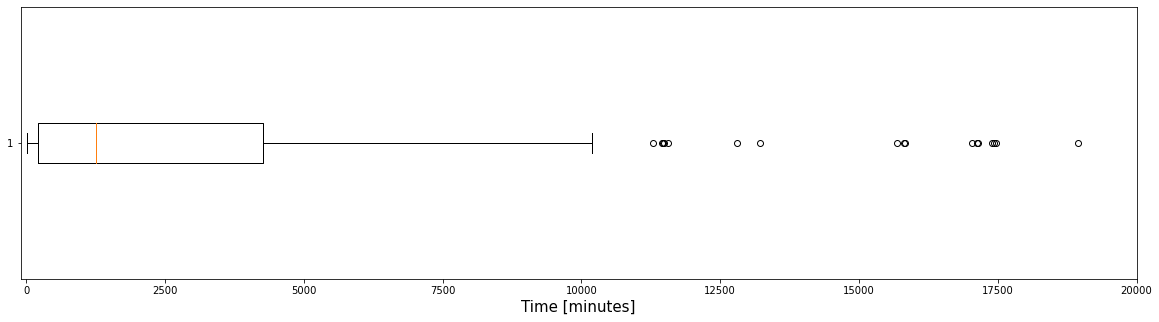

In [215]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['fire_duration'], vert=False)
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-100,20000]);

In [216]:
#plt.figure(figsize=(20,5))
#plt.boxplot(datetime_feature_engineering(noNaN_test)['time_to_ex'], vert=False);
#plt.xlabel('Time [minutes]', fontsize=15)
#plt.xlim([-100,20000]);

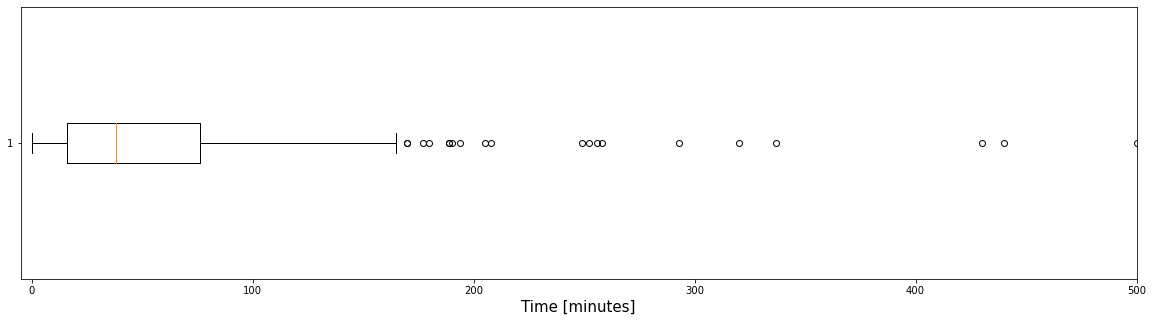

In [217]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['fire_fight_response_time'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-5,500]);

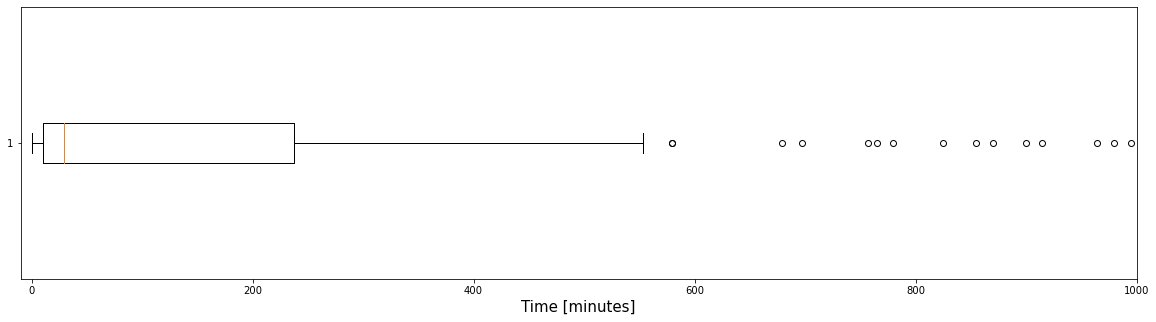

In [218]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['time_to_discover'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-10,1000]);

# Fill `fuel_type` feature
## Build model

In [8]:
# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fuel_type                       4793
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

**Note:** One of the highest unknown featues is the fuel_type which represents The predominate fuel type (vegetation cover) in which the wildfire is burning, at the time of initial assessment. The classes of this feature can be the following:

Group: Coniferous
* `C1:` Spruce-Lichen Woodland
* `C2:` Boreal Spruce
* `C3:` Mature Jack or Lodgepole Pine
* `C4:` Immature Jack or Lodgepole Pine
* `C7:` Conifer plantation

Group: Mixedwood
* `M1:` Boreal Mixedwood-Leafless
* `M2:` Boreal Mixedwood-Green

Group: Slash
* `S1:` Jack or Lodgepole Pine slash
* `S2:` White Spruce-Balsam slash

Group: Deciduous
* `D1:` Leafless Aspen

Group: Grass
* `O1a:` Matted Grass
* `O1b:` Standing Grass

In [9]:
# train non null fuel indexes
nan_fuel_indx_train = ~train['fuel_type'].isnull()
# test non null fuel indexes
nan_fuel_indx_test = ~test['fuel_type'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_fuel_indx_train], 
           test[nan_fuel_indx_test]])
## Get the features and labels
X = full_dataset.drop(['fuel_type'], 1)
y = full_dataset['fuel_type']

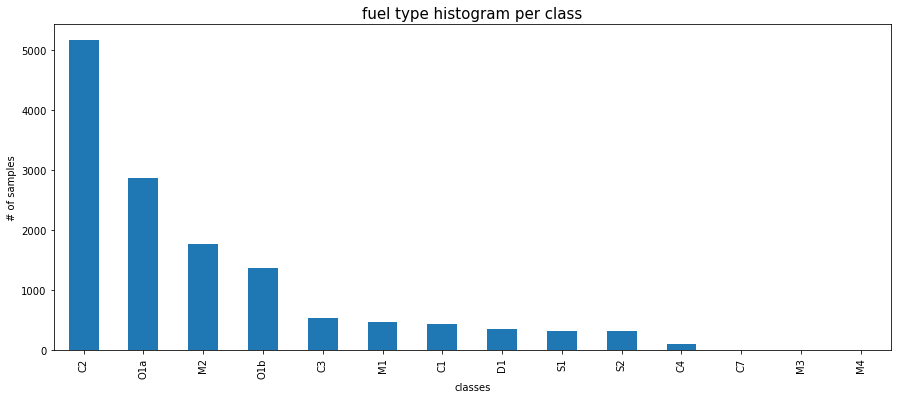

C2     5173
O1a    2878
M2     1776
O1b    1380
C3      538
M1      478
C1      446
D1      350
S1      331
S2      329
C4      112
C7       10
M3        2
M4        1
Name: fuel_type, dtype: int64

In [10]:
plt.figure(figsize=(15,6))
full_dataset['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['fuel_type'].value_counts()

In [11]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)

In [12]:
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)

In [13]:
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)

In [14]:
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)

In [15]:
# get rid of very low classes
no_M4_M3_C7_indx = (y!='M4') & (y!='M3') &((y!='C7'))

In [16]:
train_X, validation_X, train_y, validation_y = train_test_split(X[no_M4_M3_C7_indx], y[no_M4_M3_C7_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_M4_M3_C7_indx])

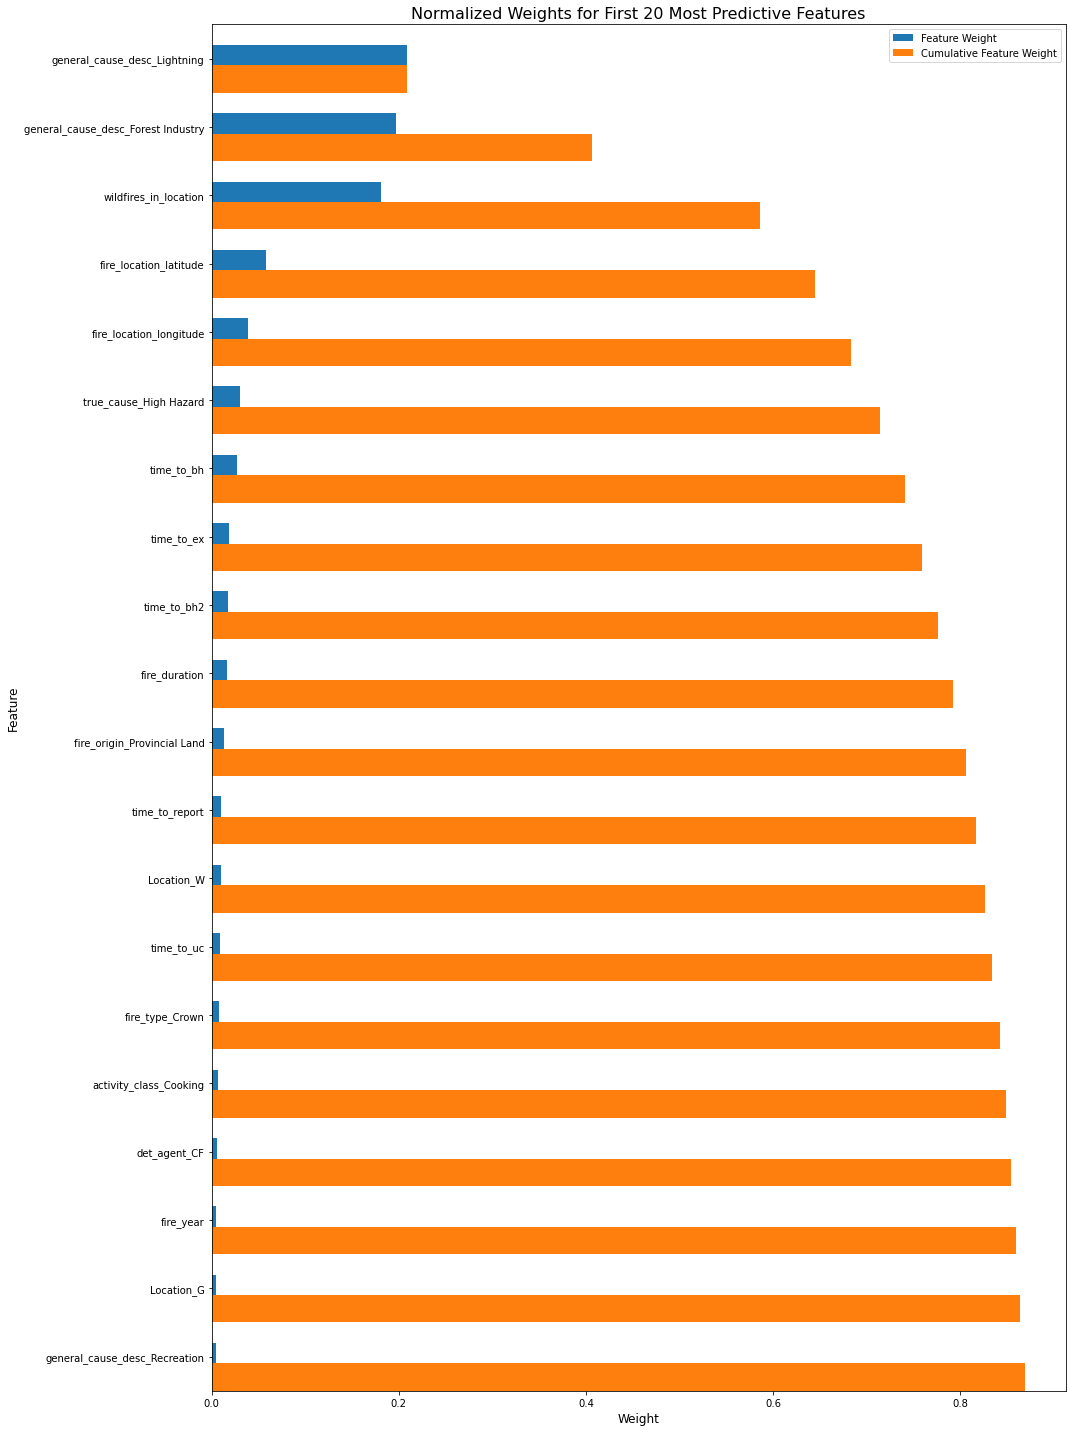

,Features,Importance value
0,general_cause_desc_Lightning,0.208832
1,general_cause_desc_Forest Industry,0.197058
2,wildfires_in_location,0.180390
3,fire_location_latitude,0.058429
4,fire_location_longitude,0.038655
5,true_cause_High Hazard,0.030272
6,time_to_bh,0.027318
7,time_to_ex,0.018052
8,time_to_bh2,0.017129
9,fire_duration,0.016429


In [17]:
model = GradientBoostingClassifier(random_state=42, learning_rate=0.5, n_estimators=50, 
                                   max_depth=3)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
relevant_df = feature_plot(importances, train_X, train_y, top_k=20)
relevant_df

In [130]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca_X = pca.fit_transform(X[no_M4_M3_C7_indx])
pca = PCA(n_components=25)
pca_train_split_X = pca.fit_transform(train_X)
pca_validation_split_X =  pca.transform(validation_X)

In [132]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#weights = {'C4': 1, 'S2': 1.8, 'S1': 3, 'D1': 3.75, 'C1': 9.6,
#           'M1': 10.8, 'C3': 11.6, 'O1b': 14.8, 'M2':15.63, 'O1a':15.72, 'C2':46.18}
#weights = {'C4': 10, 'S2': 11.8, 'S1': 14, 'D1': 15.75, 'C1': 9.6,
#           'M1': 20.8, 'C3': 17.6, 'O1b': 14.8, 'M2':29.63, 'O1a':15.72, 'C2':16.18}

#model = BalancedRandomForestClassifier(n_estimators=150, max_depth=10,
#                                       random_state=42, class_weight=weights,n_jobs = 1,
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
#                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=50)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_M4_M3_C7_indx], y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, pca_X, y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.307


In [133]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.31460781009422606
Geometric mean - validation:0.3549685402201809
Geometric mean per class - validation:[0.58156904 0.65713075 0.62962812 0.53272208 0.5358808  0.48760169
 0.52318532 0.67292774 0.59155173 0.51773537 0.66177666]
-------------------------------------------------------------------------------------------
F1-score - train:0.4241216869235656
Geometric mean - train:0.5128515875158052
Geometric mean per class - train:[0.64864323 0.67630565 0.69379977 0.89017409 0.75249901 0.64716854
 0.563376   0.67823543 0.66241678 0.71746316 0.7832119 ]


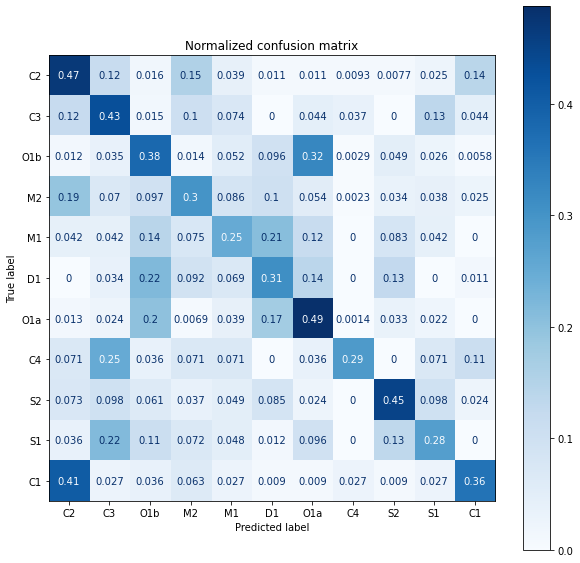

In [134]:
from sklearn.metrics import plot_confusion_matrix

class_names = validation_y.unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, validation_X, validation_y.values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

## Predicting on missing data to fill their values

In [135]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['fuel_type'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['fuel_type'].isnull()

In [136]:
## Preprocess data
train_features = train.drop(['size_class', 'fuel_type'], 1)[nan_fuel_indx_train]
test_features = test.drop(['fuel_type'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [137]:
inx = [s not in train_X.columns for s in train_features.columns]
train_features.columns[inx]

Index([], dtype='object')

In [138]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [139]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

M2    633
C2    236
C1    194
C3    167
C4     11
S1      3
S2      2
M1      1
Name: test, dtype: int64

In [140]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

M2    2489
C2     907
C1     791
C3     555
C4      31
S1       8
M1       6
S2       6
Name: train, dtype: int64

In [141]:
# Saving the model
save_model('./fuel_model3.pkl', model)

In [142]:
# Loading the model
model2 = load_model('./fuel_model3.pkl')

In [143]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

M2    633
C2    236
C1    194
C3    167
C4     11
S1      3
S2      2
M1      1
Name: test2, dtype: int64

## fill dataset and save it with model

In [144]:
## non null indexes
non_null_indx_train = ~train['fuel_type'].isnull()
non_null_indx_test = ~test['fuel_type'].isnull()

In [145]:
## null indexes
null_indx_train = train['fuel_type'].isnull()
null_indx_test = test['fuel_type'].isnull()

#### Non null data

In [146]:
train[non_null_indx_train].fuel_type.value_counts()

C2     4125
O1a    2325
M2     1435
O1b    1127
C3      428
M1      378
C1      364
D1      278
S2      269
S1      253
C4       89
C7        8
M3        2
M4        1
Name: fuel_type, dtype: int64

In [147]:
test[non_null_indx_test].fuel_type.value_counts()

C2     1048
O1a     553
M2      341
O1b     253
C3      110
M1      100
C1       82
S1       78
D1       72
S2       60
C4       23
C7        2
Name: fuel_type, dtype: int64

#### Null data

In [148]:
train[null_indx_train].fuel_type.isnull().value_counts()

True    4793
Name: fuel_type, dtype: int64

In [149]:
test[null_indx_test].fuel_type.isnull().value_counts()

True    1247
Name: fuel_type, dtype: int64

### Filling data

In [150]:
train.loc[null_indx_train, 'fuel_type'] = model.predict(train_features)
test.loc[null_indx_test, 'fuel_type'] = model.predict(test_features)

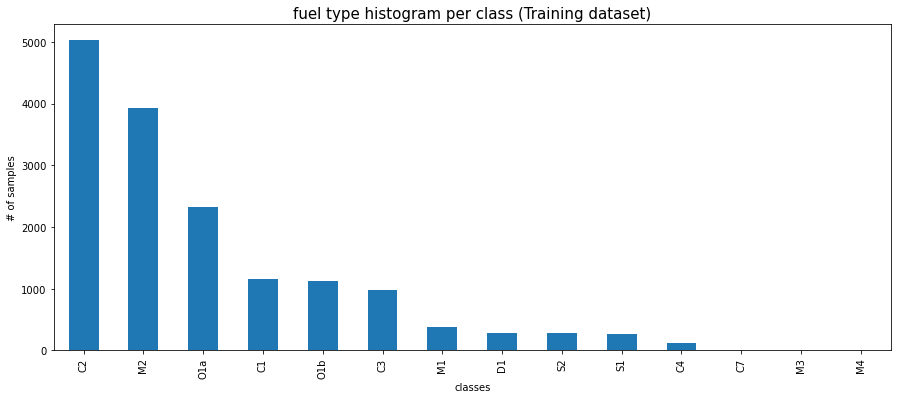

C2     5032
M2     3924
O1a    2325
C1     1155
O1b    1127
C3      983
M1      384
D1      278
S2      275
S1      261
C4      120
C7        8
M3        2
M4        1
Name: fuel_type, dtype: int64

In [151]:
plt.figure(figsize=(15,6))
train['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class (Training dataset)', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
train['fuel_type'].value_counts()

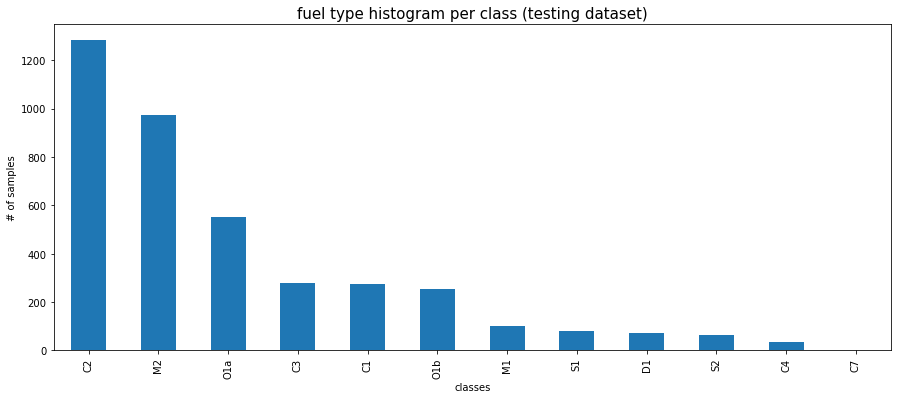

C2     1284
M2      974
O1a     553
C3      277
C1      276
O1b     253
M1      101
S1       81
D1       72
S2       62
C4       34
C7        2
Name: fuel_type, dtype: int64

In [152]:
plt.figure(figsize=(15,6))
test['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class (testing dataset)', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
test['fuel_type'].value_counts()

## saving data back to csv Files

In [153]:
file_name = 'train_fuel.csv'
train.to_csv(file_name, encoding='utf-8', index=False)

In [154]:
file_name = 'test_fuel.csv'
test.to_csv(file_name, encoding='utf-8', index=False)

# Fill `true_cause` feature
## Build model

In [17]:
# Loading the dataset
train = pd.read_csv('train_fuel2.csv')
test = pd.read_csv('test_fuel2.csv')
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

In [18]:
# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [19]:
# train non null fuel indexes
nan_trueCause_indx_train = ~train['true_cause'].isnull()
# test non null fuel indexes
nan_trueCause_indx_test = ~test['true_cause'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_trueCause_indx_train], 
           test[nan_trueCause_indx_test]])
## Get the features and labels
X = full_dataset.drop(['true_cause'], 1)
y = full_dataset['true_cause']

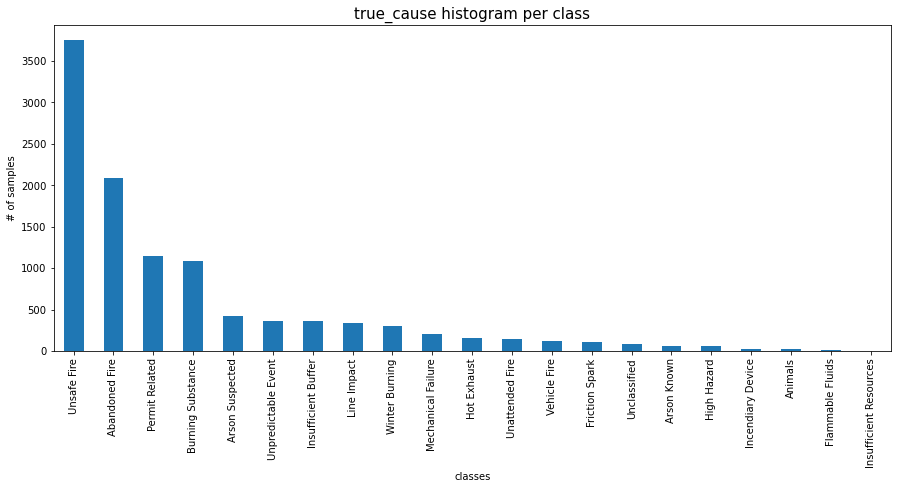

Unsafe Fire               3747
Abandoned Fire            2084
Permit Related            1147
Burning Substance         1089
Arson Suspected            423
Unpredictable Event        363
Insufficient Buffer        361
Line Impact                343
Winter Burning             300
Mechanical Failure         203
Hot Exhaust                155
Unattended Fire            143
Vehicle Fire               117
Friction Spark             108
Unclassified                83
Arson Known                 59
High Hazard                 58
Incendiary Device           25
Animals                     25
Flammable Fluids            17
Insufficient Resources       4
Name: true_cause, dtype: int64

In [20]:
plt.figure(figsize=(15,6))
full_dataset['true_cause'].value_counts().plot(kind='bar');
plt.title('true_cause histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['true_cause'].value_counts()

In [21]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)
# get rid of very low classes
no_Insfficnt_Resrcs_indx = (y!='Insufficient Resources')
train_X, validation_X, train_y, validation_y = train_test_split(X[no_Insfficnt_Resrcs_indx], 
                                                                y[no_Insfficnt_Resrcs_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_Insfficnt_Resrcs_indx])

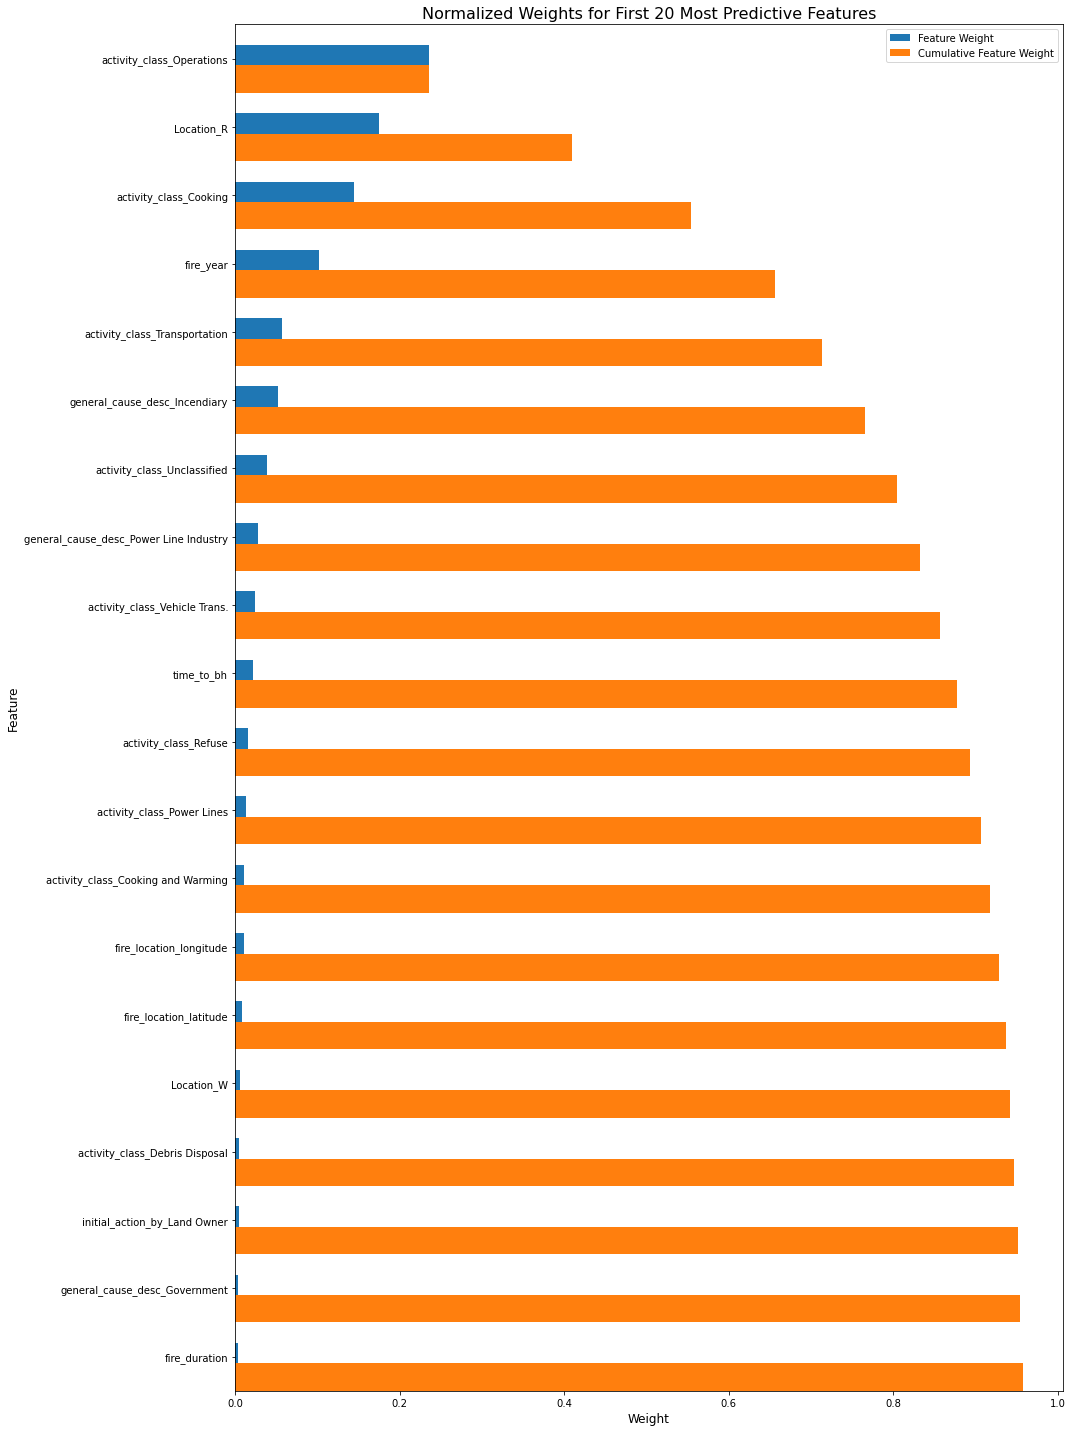

,Features,Importance value
0,activity_class_Operations,0.235322
1,Location_R,0.174755
2,activity_class_Cooking,0.144315
3,fire_year,0.102281
4,activity_class_Transportation,0.056566
5,general_cause_desc_Incendiary,0.052579
6,activity_class_Unclassified,0.038674
7,general_cause_desc_Power Line Industry,0.028291
8,activity_class_Vehicle Trans.,0.023638
9,time_to_bh,0.021465


In [22]:
model = GradientBoostingClassifier(random_state=42, learning_rate=0.5, n_estimators=50, 
                                   max_depth=3)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
relevant_df = feature_plot(importances, train_X, train_y, top_k=20)
relevant_df

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#weights = {'C4': 1, 'S2': 1.8, 'S1': 3, 'D1': 3.75, 'C1': 9.6,
#           'M1': 10.8, 'C3': 11.6, 'O1b': 14.8, 'M2':15.63, 'O1a':15.72, 'C2':46.18}
#weights = {'C4': 10, 'S2': 11.8, 'S1': 14, 'D1': 15.75, 'C1': 9.6,
#           'M1': 20.8, 'C3': 17.6, 'O1b': 14.8, 'M2':29.63, 'O1a':15.72, 'C2':16.18}

#model = BalancedRandomForestClassifier(n_estimators=150, max_depth=10,
#                                       random_state=42, class_weight=weights,n_jobs = 1,
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
#                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=50)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, pca_X, y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.476


In [25]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.45736919661359937
Geometric mean - validation:0.0
Geometric mean per class - validation:[0.85047471 0.         0.68160917 0.94006969 0.4405181  0.85896355
 0.88536573 0.65319672 0.74202509 0.40734241 0.91770497 0.87286383
 0.13987011 0.85364253 0.494837   0.89906671 0.51011347 0.89017111
 0.84635323 0.95491228]
-------------------------------------------------------------------------------------------
F1-score - train:0.55049474112335
Geometric mean - train:0.6423258488947863
Geometric mean per class - train:[0.86279935 0.85527007 0.79649096 0.95212516 0.50306613 0.99227692
 0.85132928 0.86474034 0.86675668 0.88671554 0.90365124 0.9143234
 0.38877402 0.87452382 0.60560342 0.87050726 0.58619532 0.87890269
 0.89855824 0.94183618]


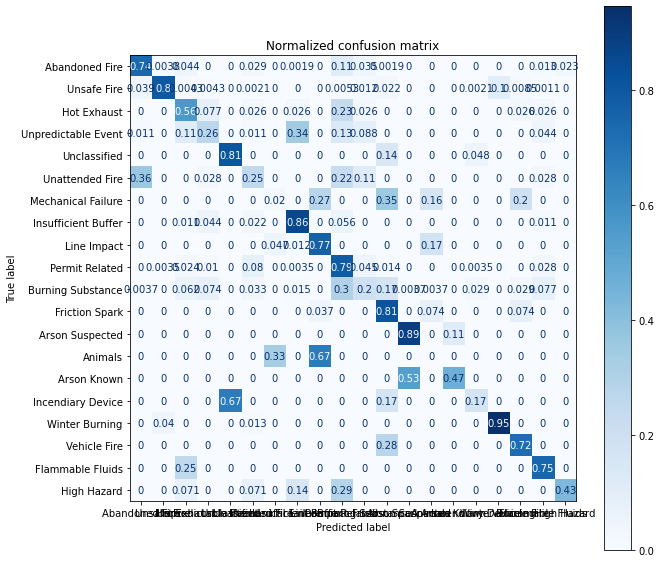

In [26]:
from sklearn.metrics import plot_confusion_matrix

class_names = validation_y.unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, validation_X, validation_y.values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

## Predicting on missing data to fill their values

In [27]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['true_cause'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['true_cause'].isnull()

## Preprocess data
train_features = train.drop(['size_class', 'true_cause'], 1)[nan_fuel_indx_train]
test_features = test.drop(['true_cause'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [28]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [29]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

Friction Spark         687
Hot Exhaust            411
Unpredictable Event    326
Unclassified           141
Unattended Fire        105
Arson Suspected         33
Incendiary Device       28
Unsafe Fire             26
Vehicle Fire            14
Flammable Fluids         8
Burning Substance        7
Insufficient Buffer      6
Permit Related           3
Line Impact              1
Name: test, dtype: int64

In [30]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

Friction Spark         2767
Hot Exhaust            1602
Unpredictable Event    1394
Unclassified            545
Unattended Fire         421
Arson Suspected         112
Incendiary Device        92
Vehicle Fire             91
Unsafe Fire              69
Flammable Fluids         41
Insufficient Buffer      33
Burning Substance        11
Permit Related            7
Winter Burning            4
Mechanical Failure        2
Abandoned Fire            2
Arson Known               1
Name: train, dtype: int64

In [31]:
# Saving the model
save_model('./true_cause_model.pkl', model)

In [32]:
# Loading the model
model2 = load_model('./true_cause_model.pkl')

In [33]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

Friction Spark         687
Hot Exhaust            411
Unpredictable Event    326
Unclassified           141
Unattended Fire        105
Arson Suspected         33
Incendiary Device       28
Unsafe Fire             26
Vehicle Fire            14
Flammable Fluids         8
Burning Substance        7
Insufficient Buffer      6
Permit Related           3
Line Impact              1
Name: test2, dtype: int64

## fill dataset and save it with model

In [34]:
## non null indexes
non_null_indx_train = ~train['true_cause'].isnull()
non_null_indx_test = ~test['true_cause'].isnull()
## null indexes
null_indx_train = train['true_cause'].isnull()
null_indx_test = test['true_cause'].isnull()

In [35]:
train.loc[null_indx_train, 'true_cause'] = model.predict(train_features)
test.loc[null_indx_test, 'true_cause'] = model.predict(test_features)

## saving data back to csv Files

In [36]:
file_name = 'train_fuel_plus_true_cause.csv'
train.to_csv(file_name, encoding='utf-8', index=False)
file_name = 'test_fuel_plus_true_cause.csv'
test.to_csv(file_name, encoding='utf-8', index=False)